# py4DSTEM Tutorial - Constructing Probe Templates
---

### Table of Contents

* [Part 0 - Download the datasets.](#part_00)
* [Part 1 - Probe template from vacuum scan.](#part_01)
* [Part 2 - Probe template from vaccum region of an experiment.](#part_02)
* [Part 3 - Probe template from thin region of an experiment.](#part_03)
* [Part 4 - Synthetic probe template.](#part_04)


### Introduction

This is a tutorial notebook for constructing STEM probe template images. The goal is to measure or approximate the image of a STEM probe in vacuum (i.e. no scattering from a sample), and shift it to the origin. These "probe templates" can be used for:
1. Bragg disk detection using correlation.
2. Bragg disk detection using machine learning networks.
3. Calibration of the probe semiangle, ellipticity, or other probe geometric parameters.
4. Inital probe intensity distribution for ptychographic reconstructions.

There are 4 methods of constructing a probe template covered in this tutorial.  In order from best to worst, they are:
1. Immediately after completing on or more 4D-STEM experiments: Move the sample out of the way, and record of a series of images of the STEM probe under the exact same imaging conditions, with no scanning.
2. Average a subset of images from an experimental dataset, where the probe passes through vacuum.
3. Average a subset of images from an experimental dataset, where the probe passes though the thinnest posisble region of the sample.
4. Construct a synthetic probe image.

These 4 methods in order correspond to the 4 parts of this tutorial.

### Acknowledgements

This tutorial was written by Colin Ophus at Berkeley Lab (clophus@lbl.gov).
The 4D-STEM datasets used here were collected by:
1. Clarissa Bhargava
2. Sean Mills
3. Karen Bustillo
4. Shiteng Zhao

### Version
Last updated on 2021-06-01 with py4DSTEM version 0.12.0.

# Part 0 - Download the datasets used in this tutorial <a class="anchor" id="part_00"></a>

You can download the 4 tutorial datasets here: 
1. [part 1](https://drive.google.com/file/d/1QTcSKzZjHZd1fDimSI_q9_WsAU25NIXe/view?usp=sharing)
2. [part 2](https://drive.google.com/file/d/1iBSANFQT9eacpn7aAE6PmFdIRYQxenGg/view?usp=sharing)
3. [part 3](https://drive.google.com/file/d/1p9GaV0k628_afbdqFW62rHObcjQ09qyl/view?usp=sharing)
4. [part 4](https://drive.google.com/file/d/1sUrPEgM1wWyTh-LJ30lGUhcXklHj6ajC/view?usp=sharing). 

Once you have downloaded all 4, uppdate the variables `file_path_example_##` in the next cell to reflect that path to the file.

In [302]:
# Set the file paths for the input datasets.
# The location of these files may be different, depending on your operating system and browser download path.
# If you are running this tutorial on Binder, you do not need to change these paths.
file_path_example_01 = 'c:/data/vacuum_probe_20x20.dm4'
file_path_example_02 = 'c:/data/bullseye_probe_scan_edge.dm4'
file_path_example_03 = 'c:/data/NiPt_nanoparticle_20x20.dm3'
file_path_example_04 = 'c:/data/twinBoundary_ShitengZhao20190115MEA.h5'

In [303]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [403]:
# Initialization - import the needed packages (for this tutorial, you only need py4DSTEM and numpy for basic operations, and Gaussian filtering from scipy)
import py4DSTEM
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_erosion 

---
# Part 1 - Building a probe template from a vacuum scan <a class="anchor" id="part_01"></a>
---
The ideal method to construct a probe template image is to measure it directly on the microscope.  Here are some best practices:
1. Record the vacuum scan immediately after you have finished your experiments (or before).
2. **Keep the microscope settings identical to the experiments**, except in the case of a beamstop.  If you are using a beamstop, you can spread the beam above the condenser aperture to reduce the brightness, and then move the beamstop out of the way before recording the vacuum scan.
3. Record more than one image. Remember that even in vacuum, your measurement is affected by Poisson shot noise (limited electron counts) and detector readout noise.
4. Do not scan the beam while recording the vacuum template. We can easily remove the shifts of the beam center position due to STEM coil de-scan, but this is not necessary if you do not move the probe.

In [305]:
# Load example 1, a 20 x 20 scan where the probe does not move and no sample is present.
dataset_01 = py4DSTEM.io.read(file_path_example_01)

# Display the size of the dataset
print(dataset_01.data.shape)

(400, 1, 512, 512)


We see the dataset size is `[400 x 1]` probe positions, composed of CBED images each having a size of `[512 x 512]` pixels.

The data is 3D rather than 4D because this data was recorded as a "time series" with a custom dm3 recording script on our Titan.

For this example, we don't technically need to reshape the dimensions of this array to be `[20 x 20 x 512 x 512]`, but it's a good habit and will be useful for the other examples in this tutorial.

In [30]:
# Reshape the scan size from [400 x 1] to [20 x 20]
dataset_01.set_scan_shape(20, 20)
print(dataset_01.data.shape)

(20, 20, 512, 512)


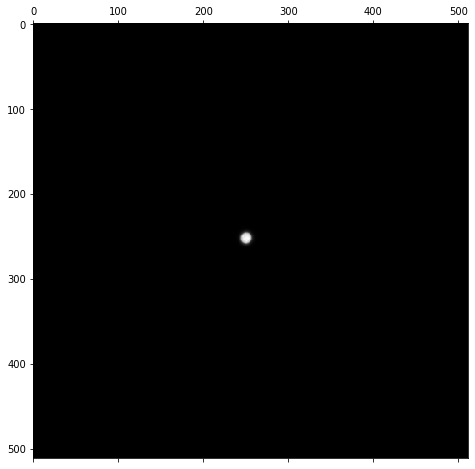

In [42]:
# Let's examine the diffraction pattern data by looking at the mean CBED image.
diffraction_pattern_mean_01 = np.mean(dataset_01.data, axis=(0,1))
py4DSTEM.visualize.show(diffraction_pattern_mean_01)

The above image looks like it should - An isolated probe near the center of the field of view, with a circular shape given by the condenser aperture used. However, you will now learn how to closely inspect this data to verify a few facts:
1. The probe is really in vacuum
2. The STEM beam was not scanned while this data was recorded.

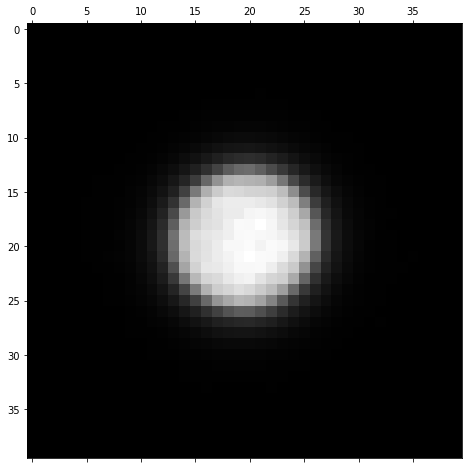

In [84]:
# Zoom in on the probe for a closer look - note that numpy array indexing is always [row, column]
x_range = np.arange(-20,20) + 253  # range of x axis pixels to plot (rows)  
y_range = np.arange(-20,20) + 251  # range of y axis pixels to plot (columns)

# Feel free to move around the center coordinate (253, 251) or change the cropped sizes from (-20:20) to other dimensions
py4DSTEM.visualize.show(diffraction_pattern_mean_01[x_range, y_range[:, None]])

In [87]:
# Now, lets change the plotting color range to verify the vacuum region really is vacuum (close to zero signal).
# Step 1 is getting the minimum and maximum ranges (which are set to black and white color levels respectively above)
print(np.min(diffraction_pattern_mean_01),np.max(diffraction_pattern_mean_01))

0.04 6425.9


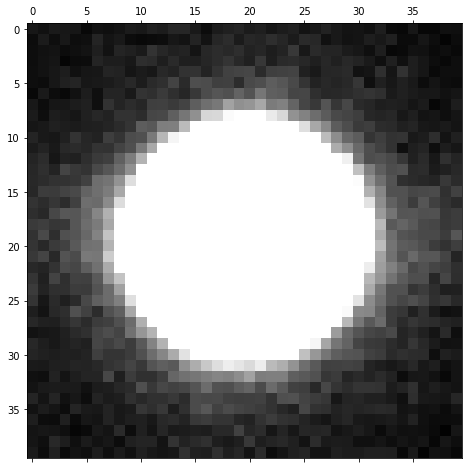

In [94]:
# We see that the min intensity is essentially zero, and the max is 6425.9 counts (note this is some factor * # of electrons).

# Let's scale the plotting range to be from 0 to 1% of the maximum recorded counts.
# clipvals='manual' will set the intensity range scaling to be manually specified by the user,
# while min and max specify the intensity values assigned to black and white respectively.
py4DSTEM.visualize.show(diffraction_pattern_mean_01[x_range, y_range[:, None]],
                        clipvals='manual',
                        min=0,
                        max=np.max(diffraction_pattern_mean_01) * 0.01)

We see that the probe intensity falls off extremely rapidly to zero. 

A small "*bloom*" is visible a few pixels out, which is due to the camera scintillator causing a slight point spread function. However since this extra intensitiy is significantly less than 1% of the peak intensity, it will not cause any issues.

Next, we will perform a quick manual check to see if the probe shows movement between scan positions. We can perform this check in several ways, but here we will simply plot the difference in measured intensity for probes at different scan positions in the dataset. 

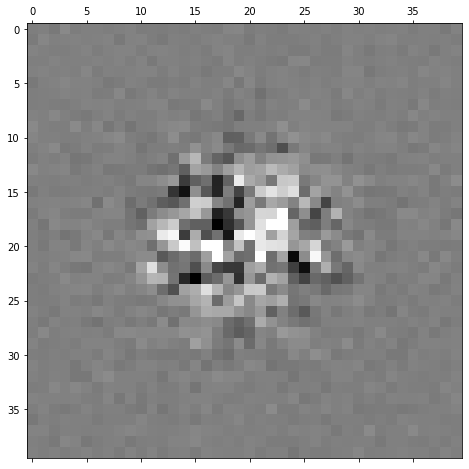

In [107]:
# Calculate the difference between two images along row 10, the left-most (index 0) and right-most images (index -1).
# This data consists of unsigned integers, which cannot display negative values. We therefore convert the images to floating point.
diffraction_image_diff = dataset_01.data[10,0,:,:].astype(float) \
                       - dataset_01.data[10,-1,:,:].astype(float)
 # Note, the backslash \ just means "go to next line"

# Plot the ranges from -5% to +5% of the maximum value
py4DSTEM.visualize.show(diffraction_image_diff[x_range, y_range[:, None]],
                        clipvals='manual',
                        min=np.max(diffraction_pattern_mean_01) * -0.05,
                        max=np.max(diffraction_pattern_mean_01) * 0.05)

First, we see why many images should be averaged to create the probe template - intensity fluctuations of +/-5% are clearly visible between images. This is due to the poisson noise statistics (shot noise) for a finite electron dose experiment. The vacuum probe on average will have a much smoother intensity distribution, and so we must average many images to approximate it.

Additionally, we can see in the above image that the probe does not appear to be shifted (as expected for this experiment).  Let's take a quick look at what we would see if the probe were shifting during the recording of this data.

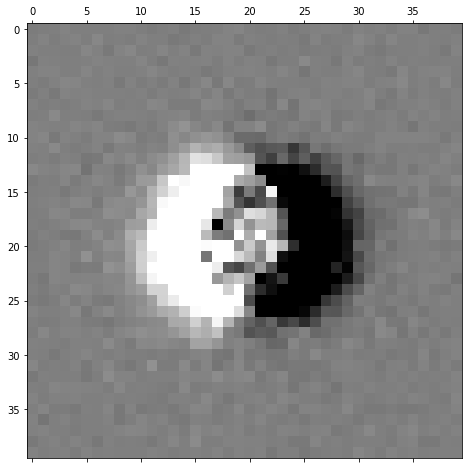

In [117]:
# Deliberately introduce a shift between two probe images - try different shifts such as -1, or changing axis=0 to axis=1
diffraction_image_diff = dataset_01.data[10,0,:,:].astype(float) \
                       - np.roll(dataset_01.data[10,-1,:,:].astype(float), 1, axis=0)

# Plot the difference image
py4DSTEM.visualize.show(diffraction_image_diff[x_range, y_range[:, None]],
                        clipvals='manual',
                        min=np.max(diffraction_pattern_mean_01) * -0.05,
                        max=np.max(diffraction_pattern_mean_01) * 0.05)

As we can see, even a single pixel shift is **very** obvious in the difference image. 

It's important to remove any shifts if they are present -for example, a probe template with a diameter of 10 pixels which is shifted 2 pixels during the scan and then averaged will have an apparent diameter of ~12 pixels and a different edge shape (much less steep). This in turn makes the correlation image for Bragg peak detection less accurate.

### Build the probe template image

Now that we have verified the dataset quality, it's time to construct the probe template. When using a correlation image to detect and locate Bragg peaks, the image (array) origin is always in the upper left corner.  Since a correlation image displays maxima at shifts *relative* to each other (where the image contents agree) we need to be careful about our output coordinates.

For example, say we have a probe template centered at index position `[250, 250]`, and we are detecting a Bragg disk in another diffraction image located at `[300, 400]`. If we naively take the 2D correlation of these images, we will observe a maximum at `[50, 150]`. This is because the probe template needs to be shifted `[50, 150]` pixels to *best agree* with the 2nd diffraction image. 

However, we could intepret the correlation output a lot more easily if the detected Bragg disk were located at pixel `[300, 400]`. We can achieve this outcome in a very simple way - simply move the probe template to the origin pixel at `[0, 0]`. If we then take the correlation of this shifted probe template with the diffraction image containing a Bragg disk centered on `[300, 400]`, the correlation image will also display a maximum value at pixel `[300, 400]`.

### Normalization of probe template images

We also typically want to normalize the probe template. We do this in two ways - first, we divide the probe template by its total intensity sum, such that it has an intensity sum of 1. This ensures that the correlation output intensity for each Bragg disk is roughly equal to the total integrated intensity inside the disk, generating more interpretable outputs. This is also useful for applying global intensity thresholds to the measured Bragg intensity values.

Second, we often wany to reduce the effect of the *local environment* in Bragg disk detection. A Bragg disk located very close to the origin may be sitting on a large background signal, while Bragg disks at high scattering angles may have almost no background present. We want the Bragg disk detection routines to be relatively independent of the local background signal. We usually accomplish this by subtracting a normalization kernel from the probe template which also sums to 1, giving a total intensity sum for the template of zero. We typically choose either a 2D Gaussian distribution, or a 2D sigmoid / logistic function for this normalization kernel, both with in-plane dimensions larger than the probe itself.  The Gaussian distribution produces the smoothest output intensity, but may also introduce errors near other peaks due to the longer tail of the distribution. We use a sigmoid / logistic function typically when we want smaller tails on the normalized probe template. 

### Masking of probe template images

Another consideration is masking off the probe. This is the process of ensuring that pixels far from the probe are set to zero.  The detector noise may only be equal to small values in each pixel, but these signals can add up when considering thousands or even millions of detector pixels. The function:
`py4DSTEM.process.diskdetection.get_probe_from_vacuum_4Dscan` both aligns the input images and masks them off, with a default mask size of 12 pixels from the estimate probe edge. This function has several additional tunable parameters, but these will not be examined here.

---

Lastly, we want to emphasize that Bragg disk detection always requires hyperparameter tuning of some form, including modifying the probe template functions. This is because there is always a tradeoff between the number of false positives measured (seeing Bragg disks that aren't there) and the number of false negatives (missing Bragg peaks which are there). At small enough electron doses / Bragg peak excitation values, there will always be borderline peaks which we must use our judgement in deciding whether to include or not. This *hyperparameter tuning* can be done in a statistically optimal way, but that subject will be covered in another tutorial.

100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 349.48it/s]


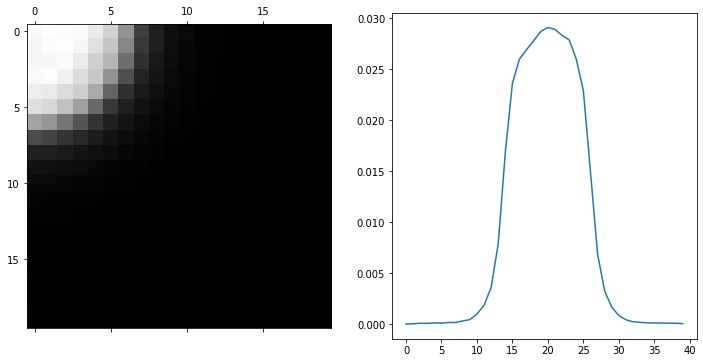

Sum of probe template = 1.0


In [217]:
# Mask off the mean vacuum probe image
probe_masked_01 = py4DSTEM.process.diskdetection.get_probe_from_vacuum_4Dscan(dataset_01, align=False)

# Generate a probe template from the mean diffraction image, without subtracting a normalization kernel
probe_kernel_01 = py4DSTEM.process.diskdetection.get_probe_kernel(probe_masked_01)

# Plot the probe kernel
# -left image shows 1/4 of the periodic probe image out to a radius of 20 px, now centered on [0, 0].
# -Right plot shows line trace 4 px wide.
py4DSTEM.visualize.show_kernel(probe_kernel_01, R=20, L=20, W=4)

# Print the sum of the probe template
print('Sum of probe template =', np.sum(probe_kernel))

The above probe template is perfectly reasonable to use for Bragg disk detection.  For the sake of completeness, we will now see how to automatically remove image shifts if the STEM probe were scanned around during the recording of this dataset. Note that this will take about 30 seconds, since each diffraction image must be aligned to a single common origin. 

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [00:35<00:00, 11.34it/s]


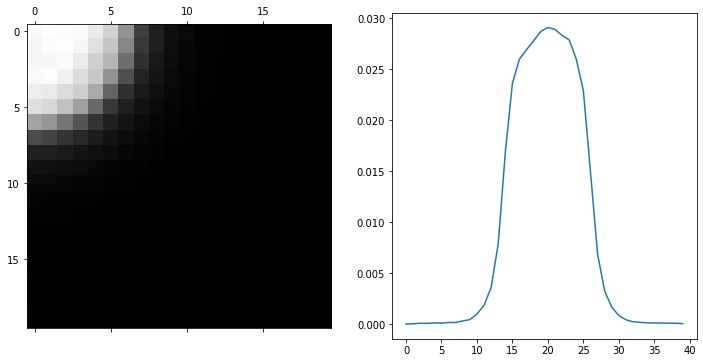

In [219]:
# align the [20 x 20] STEM probe positions to a common origin
probe_aligned_01 = py4DSTEM.process.diskdetection.get_probe_from_vacuum_4Dscan(dataset_01)

# Generate a probe template from the mean diffraction image after alignment
probe_kernel_01 = py4DSTEM.process.diskdetection.get_probe_kernel(probe_aligned_01)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel_01, R=20, L=20, W=4)

As we can see, the output is virtually unchanged - no alignment was necessary for this dataset. However, we will need to perform this alignment steps for other examples in this tutorial below.

Next, let's make some normalized probe templates by subtacting normalization kernels.  First, let's use a Gaussian distribution with a sigma value (standard deviation) equal to 2 times the estimated probe radius.

100%|███████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 336.21it/s]


Estimated probe radius = 6.39 pixels


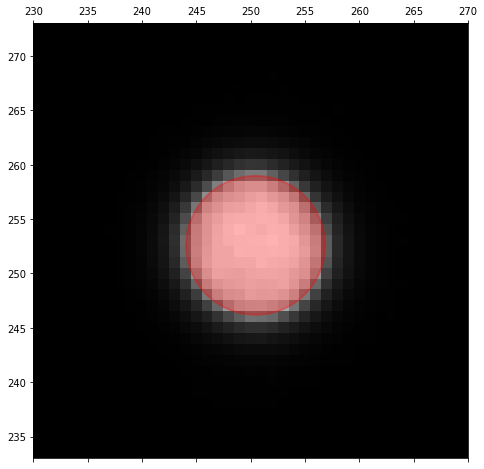

In [264]:
# Mask off the mean vacuum probe image (note we are repeating a previous step)
probe_masked_01 = py4DSTEM.process.diskdetection.get_probe_from_vacuum_4Dscan(dataset_01, align=False)

# Get the probe radius (and center coordinates)
probe_01_radius, probe_01_qx0, probe_01_qy0 = py4DSTEM.process.calibration.get_probe_size(probe_masked_01)

# plot the diffraction pattern, with the estimate probe radius overlaid as a circle
fig,ax = py4DSTEM.visualize.show_circles(diffraction_pattern_mean_01, (probe_01_qx0, probe_01_qy0), probe_01_radius, returnfig=True)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_01_radius, 'pixels')

# note that we returned the figure and axis handles so that we can zoom in on the probe. 
# Try commenting out the below commands to see why we do this.
ax.set_xlim(230, 270);
ax.set_ylim(233, 273);

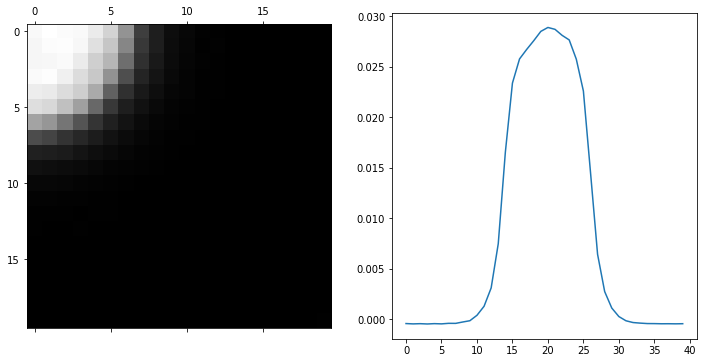

Sum of probe template = 0.000000


In [428]:
# construct a probe template by subtracting a Gaussian normalization kernel, with sigma = probe_01_radius
probe_kernel_01 = py4DSTEM.process.diskdetection.get_probe_kernel_edge_gaussian(probe_masked_01, probe_01_radius*1.0)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel_01, R=20, L=20, W=4)

# Print the sum of the probe template
print('Sum of probe template =', '%.6f' % np.sum(probe_kernel_01))

You are likely wondering why the probe looks identical to before, despite the fact that we subtracted a Gaussian normalization function.  We know the probe has indeed been normalized since the sum of all pixels is now 0 rather than 1.  So what is happening here?

The normalization kernel is not visible in the above plot because the peak of this kernel is much lower than the peak of the STEM probe. To see it more clearly, we can scale the intensity range of the output image.

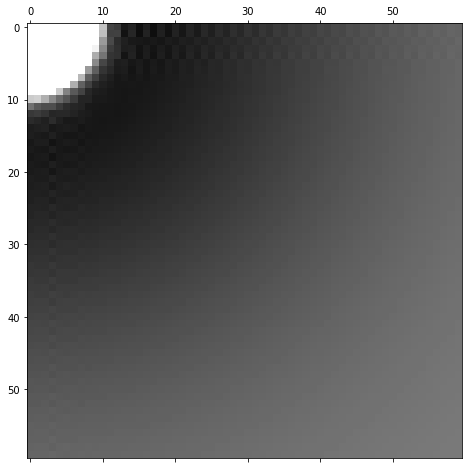

In [266]:
# Get the peak value of the probe template
probe_kernel_01_max = np.max(probe_kernel_01)

# Set the size of the image plot, starting from the origin pixel (upper left corner)
plot_size = 60

# Plot the probe template, with the intensity range scaled to +/-2% of the peak value 
py4DSTEM.visualize.show(probe_kernel_01[0:plot_size,0:plot_size],
                        clipvals='manual',
                        min=probe_kernel_01_max * -0.02,
                        max=probe_kernel_01_max * 0.02)

Now we can clearly see negative values of the normalization kernel, as well the long tails produced. This template will likely perform fairly well, but may run into issues if we are trying to detect a weak Bragg disk directly adjacent to a much strong one - the negative tail of normalization kernel combined with a much stronger neighboring Bragg disk will lead to a lower output signal. Note that this effect could be minimized by increasing the sigma value of the normalization kernel to a larger value, but at the cost of a less-localized normalization of the background.

An alternative is to normalize the probe with a function that returns to zero over a much more limited distance. We will use an "s-shaped" or sigmoid function (one family of sigmoids is the logistic function, which we will use here). More information on sigmoid functions can be found on wikipedia: https://en.wikipedia.org/wiki/Sigmoid_function

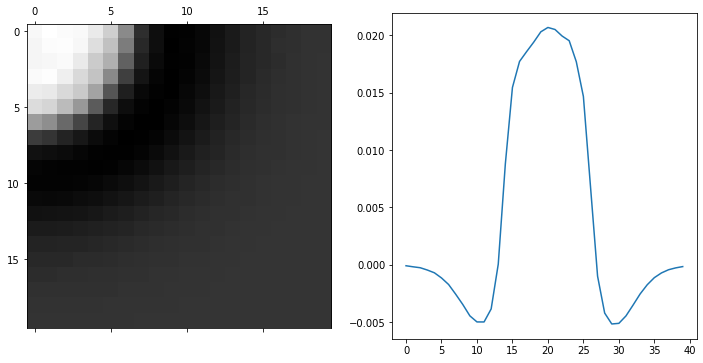

Sum of probe template = -0.000000


In [300]:
# construct a probe template by subtracting a sigmoid normalization kernel, 
# with an inner radius equal to 1.0 times the estimated probe radius, and the outer radius equal to 2.0 times the probe radius.
probe_kernel_01 = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(probe_masked_01, 
                                                                               probe_01_radius * 1.2,
                                                                               probe_01_radius * 2.4)
# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel_01, R=20, L=20, W=4)

# Print the sum of the probe template
print('Sum of probe template =', '%.6f' % np.sum(probe_kernel_01))

This normalization scheme also has the benefit of increasing the edge sensitivity of the probe template. The default sigmoid used is a logistic function, which is relatively smooth, but does have tails which reach to - and + infinite in the radial directions (though the tails do damp out quickly).  For very small semiangle STEM probes, we might want a sigmoid function with limited bandwidth (the tails of the sigmoid end at the specified values). One function that meets these criteria is a squared sinewave over the range 0 to pi/2, which is also included in `py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid`. We switch to this function in the following cell:

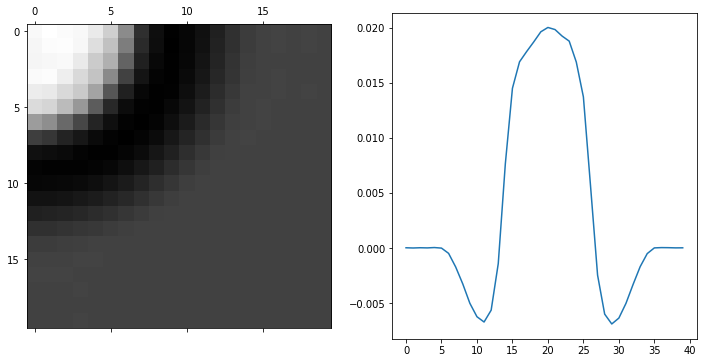

Sum of probe template = 0.000000


In [301]:
# construct a probe template with a sine_squared sigmoid normalization kernel, 
# with an inner radius equal to 1.0 times the estimated probe radius, and the outer radius equal to 2.0 times the probe radius.
probe_kernel_01 = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(probe_masked_01, 
                                                                               probe_01_radius * 1.2,
                                                                               probe_01_radius * 2.4,
                                                                               type='sine_squared')
# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel_01, R=20, L=20, W=4)

# Print the sum of the probe template
print('Sum of probe template =', '%.6f' % np.sum(probe_kernel_01))

The probe template with a sine_squared sigmoid is very similar to the logistic sigmoid, except for how quickly the tails damp out.

This concludes part 1. The following sections are considerably less detailed, assuming that we want to use the default values for the probe template construction functions. We will focus instead only on the new concepts and functions needed for the other 3 use cases.

---
# Part 2 - Building a probe template from a vacuum region of an experimental scan <a class="anchor" id="part_02"></a>
---
Sometimes we forget to record a vacuum dataset of the STEM probe. However, for many experiments, we can produce a probe template just as good as a vacuum scan. We can do this when one of our experimental datasets include probe positions measured over vacuum, such as the edge of a wedge or localized holes in the sample. In this part, we will load just such a dataset and use it to contruct a probe template.

In [487]:
# Load example 2, a 40 x 40 scan containing the edge of a sample
dataset_02 = py4DSTEM.io.read(file_path_example_02)

# Display the size of the dataset
print(dataset_02.data.shape)

(1600, 1, 512, 512)


In [309]:
# As in the previous example, we will reshape the scan size from [1600 x 1] to [40 x 40]
dataset_02.set_scan_shape(40, 40)
print(dataset_02.data.shape)

(40, 40, 512, 512)


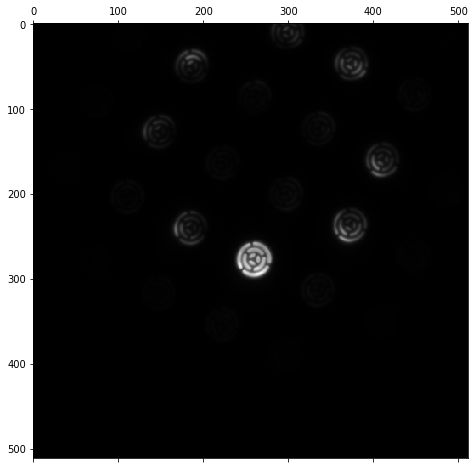

In [311]:
# Plot the mean diffraction pattern for example 2
diffraction_pattern_mean_02 = np.mean(dataset_02.data, axis=(0,1))
py4DSTEM.visualize.show(diffraction_pattern_mean_02)

Very interesting!  This probe consists of a patterned *bullseye* aperture, which is used to enhance the precision of Bragg disk position measurements. If you would you like to learn more about Bullseye apertures, we have published a paper describing them here:
https://doi.org/10.1016/j.ultramic.2019.112890
 
Note that these apertures are also available free of charge to anyone who wants one - just email me at clophus@lbl.gov.

We can also clearly see that some Bragg scattering has occured, with several additional Bragg peaks visible.

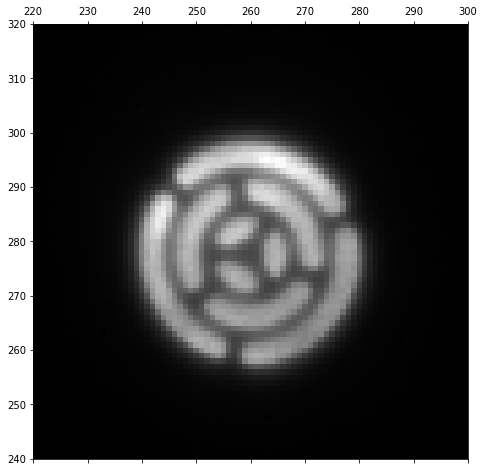

In [330]:
# Lets zoom in on center beam (which we assume is the brightest disk visible)
fig, ax = py4DSTEM.visualize.show(diffraction_pattern_mean_02, 
                                 returnfig=True)
ax.set_xlim(220, 300);
ax.set_ylim(240, 320);

In [ ]:
# Let's find the center beam position and estimate the radius

Estimated probe radius = 22.69 pixels


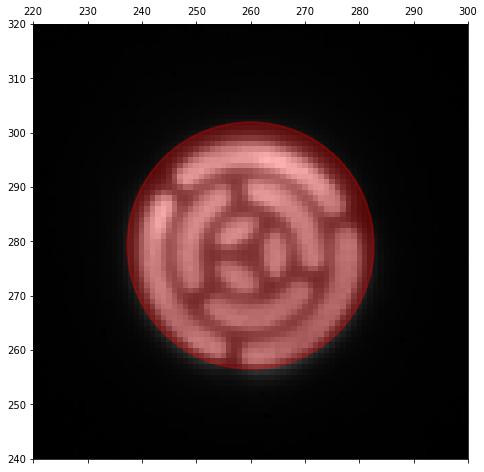

In [390]:
# Get the probe radius and center coordinates.  
# Note that as currently written, we will need to first apply Gaussian blur to the diffraction pattern image for this to work.
diffraction_pattern_blur_02 = gaussian_filter(diffraction_pattern_mean_02, sigma=5)
probe_02_radius, probe_02_qx0, probe_02_qy0 = py4DSTEM.process.calibration.get_probe_size(diffraction_pattern_blur_02,                                                                                      thresh_upper=0.6)

# plot the diffraction pattern, with the estimate probe radius overlaid as a circle
fig, ax = py4DSTEM.visualize.show_circles(diffraction_pattern_mean_02, (probe_02_qx0, probe_02_qy0), probe_02_radius, returnfig=True)
ax.set_xlim(220, 300);
ax.set_ylim(240, 320);

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_02_radius, 'pixels')

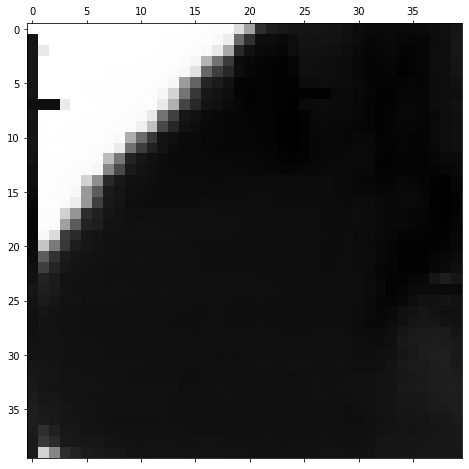

In [399]:
# Next, create a bright field (BF) virtual detector using the the center beam position, and expanding the radius slightly (3 px).
image_BF_02 = py4DSTEM.process.virtualimage.get_virtualimage_circ(dataset_02, probe_02_qx0, probe_02_qy0, probe_02_radius + 3.0)

# Show the BF image
py4DSTEM.visualize.show(image_BF_02)

The left edge of this dataset shows a missing column of data, and there are a few wraparound / streaking artifacts. However, the upper left corner clearly shows a nearly flat white region, which corresponds to the edge of the sample. Remember that in a BF image, we are imaging the unscattered electrons which are still in the center Bragg disk - the signal should be maximized over vacuum. The darker region of this BF image corresponds to the sample, where most of the electrons have been scattered to higher angles - they are outside of our virtual detector.

So, our goal is to construct the vacuum template from only those probe positions which are far fro mthe sample edge. Note that our STEM probe was scanning over the sample during this experiment, and so we must be sure to align all of the diffraction patterns to a common origin. We will use a different probe construction function, `py4DSTEM.process.diskdetection.get_probe_from_4Dscan_ROI`.

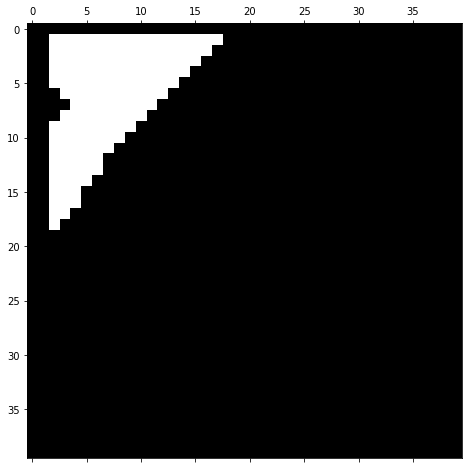

In [559]:
# First, let's transform that bright field image into a region of interest (ROI).
# In this case, our ROI is defined as a boolean array where True pixel values are the probe positions we will average.
# We will start with a threshold of 50% of the max bright field value
image_mask_02 = image_BF_02 > (np.max(image_BF_02)*0.5)

# Finally, remove the boundary pixels from the mask to ensure we are far from the sample edge.
image_mask_02 = binary_erosion(image_mask_02, iterations=1)

# Show the masked BF image
py4DSTEM.visualize.show(image_mask_02)

100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:09<00:00, 12.32it/s]


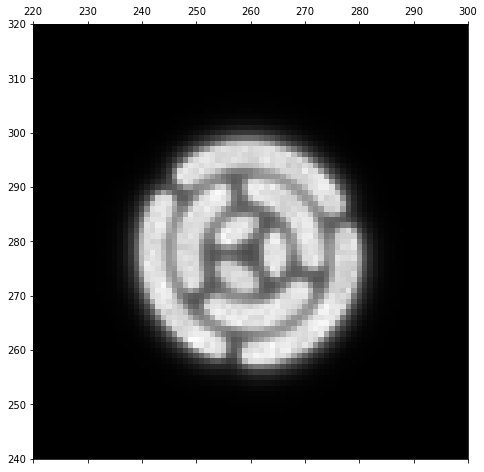

In [408]:
# Next, average all of the probe positions defined in this ROI mask
probe_aligned_02 = py4DSTEM.process.diskdetection.get_probe_from_4Dscan_ROI(dataset_02, image_mask_02, align=True)

# plot the output probe
fig, ax = py4DSTEM.visualize.show(probe_aligned_02, 
                                 returnfig=True)
ax.set_xlim(220, 300);
ax.set_ylim(240, 320);

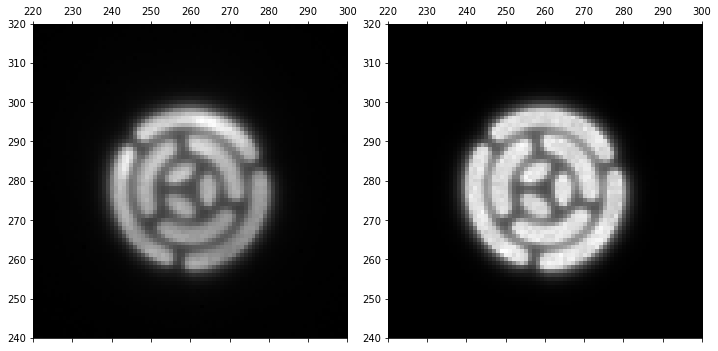

In [448]:
# The aligned probe image from the vacuum positions looks sharp and clear. Let's compare it to the mean probe position.
fig, ax = py4DSTEM.visualize.show_image_grid(
    lambda i:[diffraction_pattern_mean_02,probe_aligned_02][i],
    H=1,
    W=2,
    axsize=(5,5),
    returnfig=True)
ax[0,0].set_xlim(220, 300);
ax[0,0].set_ylim(240, 320);
ax[0,1].set_xlim(220, 300);
ax[0,1].set_ylim(240, 320);

The mean probe image is noticably sharper after aligning the individual images, even over the small scan region of the ROI. This is because the STEM probe de-scan is never perfectly aligned. Scans over very large sample regions can lead to very large probe shifts. 

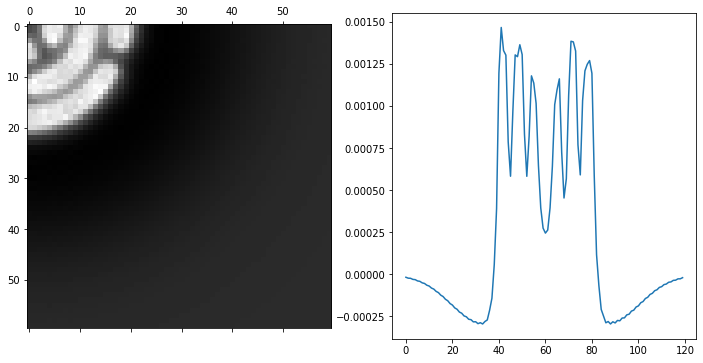

In [566]:
# The final step is to normalize the STEM probe and shift it to the origin
probe_kernel_02 = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(probe_aligned_02, 
                                                                               probe_02_radius * 1.2,
                                                                               probe_02_radius * 2.4,)
# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel_02, R=60, L=60, W=2)

Analyzed 3 diffraction patterns in 0h 0m 0s


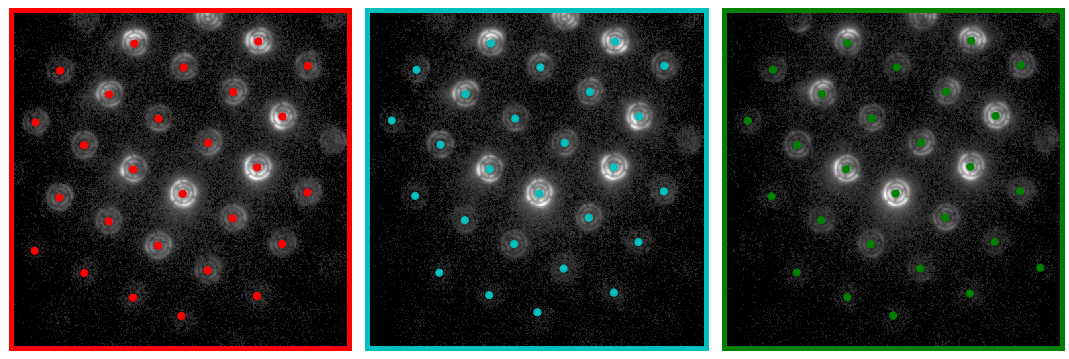

In [486]:
# Let's try this probe template out on the sample region, at 3 probe positions:
rxs = 15,25,35
rys = 15,25,35
colors=['r','c','g']

dp1 = dataset_02.data[rxs[0],rys[0],:,:]
dp2 = dataset_02.data[rxs[1],rys[1],:,:]
dp3 = dataset_02.data[rxs[2],rys[2],:,:]

# Run the disk detection on the selected DPs
corrPower=1
sigma=0
edgeBoundary=32
minRelativeIntensity=0.002
relativeToPeak=0
minPeakSpacing=30
maxNumPeaks=100
subpixel='multicorr'
upsample_factor=16

disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset_02,probe_kernel_02,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

py4DSTEM.visualize.show_image_grid(lambda i:[dp1,dp2,dp3][i],H=1,W=3,axsize=(5,5),
                                   scaling='power',
                                   power=0.25,
                                   get_bordercolor=lambda i:colors[i],
                                   get_x=lambda i:disks_selected[i].data['qx'],
                                   get_y=lambda i:disks_selected[i].data['qy'],
#                                    get_s=lambda i:disks_selected[i].data['intensity'],  
                                   get_pointcolors=lambda i:colors[i])

---
# Part 3 - Building a probe template from thin regions of a sample <a class="anchor" id="part_03"></a>
---
What do we do if we have no vacuum scan of our probe, and none of our experiments have vacuum regions? 

The next best option is to find the thinnest possible region of an experiment dataset, and average the probes in that ROI. Let's do it!

In [488]:
# Load example 3, a 20 x 20 scan of a nanoparticle
dataset_03 = py4DSTEM.io.read(file_path_example_03)

# Display the size of the dataset
print(dataset_03.data.shape)

(400, 1, 512, 512)


In [489]:
# Reshape the scan size from [400 x 1] to [20 x 20]
dataset_03.set_scan_shape(20, 20)
print(dataset_03.data.shape)

(20, 20, 512, 512)


Estimated probe radius = 16.78 pixels


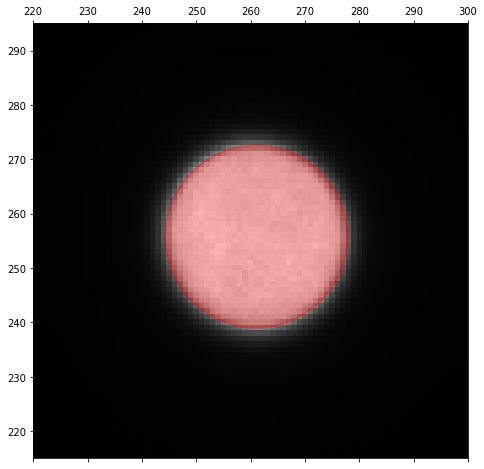

In [501]:
# Get the mean diffraction pattern for example 3
diffraction_pattern_mean_03 = np.mean(dataset_03.data, axis=(0,1))

# Estimate probe position and radius
probe_03_radius, probe_03_qx0, probe_03_qy0 = py4DSTEM.process.calibration.get_probe_size(diffraction_pattern_mean_03)

# plot the diffraction pattern, zoomed in, with the estimate probe radius overlaid as a circle
fig, ax = py4DSTEM.visualize.show_circles(diffraction_pattern_mean_03, (probe_03_qx0, probe_03_qy0), probe_03_radius, returnfig=True)
ax.set_xlim(220, 300);
ax.set_ylim(215, 295);

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_03_radius, 'pixels')

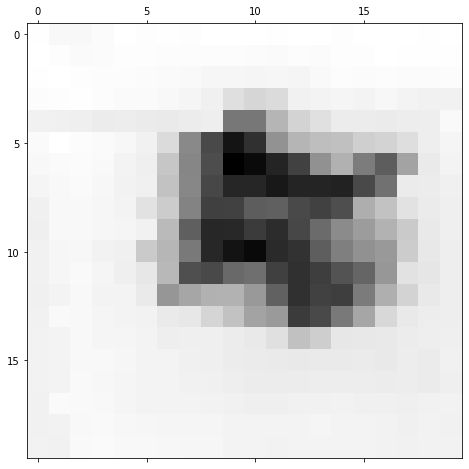

In [503]:
# Similarly to the previous exxample, create a bright field (BF) virtual detector image
image_BF_03 = py4DSTEM.process.virtualimage.get_virtualimage_circ(dataset_03, probe_03_qx0, probe_03_qy0, probe_03_radius + 4.0)

# Show the BF image
py4DSTEM.visualize.show(image_BF_03)

Let's compare diffraction patterns measured both from the substrate and from the nanoparticle.  Note that even for patterns that display no crystalline Bragg diffracted disks, low angle scattering due to the substrate is still present.

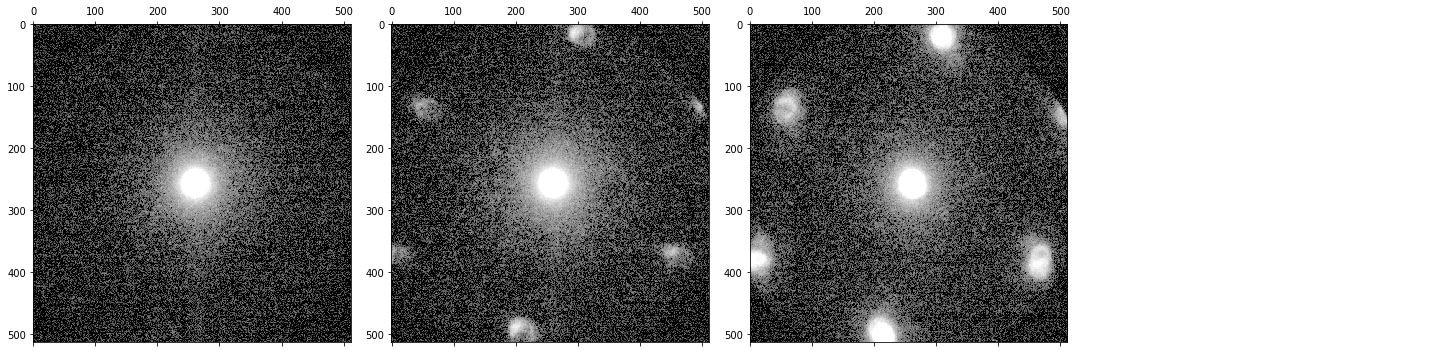

In [553]:
# plot 3 diffraction images, moving from the substrate to the nanoparticle.
rxs = 11,11,11
rys = 2,5,8

im1 = dataset_03.data[rxs[0],rys[0],:,:]
im2 = dataset_03.data[rxs[1],rys[1],:,:]
im3 = dataset_03.data[rxs[2],rys[2],:,:]

# Plot the images with intensities scaled from 0 to 200
fig, ax = py4DSTEM.visualize.show_image_grid(
    lambda i:[im1,im2,im3][i],
    H=1,
    W=4,
    clipvals='manual',
    scaling='log',
    min=0,
    max=6,
    axsize=(5,5),
    returnfig=True)

We will use exactly the same procedure as the previous section to construct a probe template.

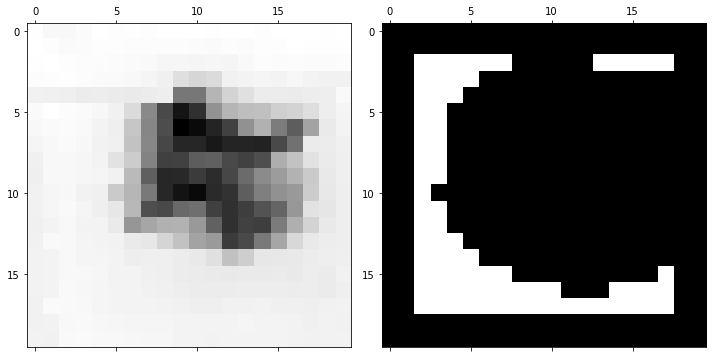

In [564]:
# We will transform the BF image into an ROI, thresholding at 90% of the max intensity (higher than the previous example)
image_mask_03 = image_BF_03 > (np.max(image_BF_03)*0.9)

# Remove the boundary pixels from the mask to ensure we are far from the sample edge.
image_mask_03 = binary_erosion(image_mask_03, iterations=2)

# Show the masked BF image right beside the BF image
py4DSTEM.visualize.show_image_grid(
    lambda i:[image_BF_03,image_mask_03][i],
    H=1,
    W=2,
    axsize=(5,5))

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.47it/s]


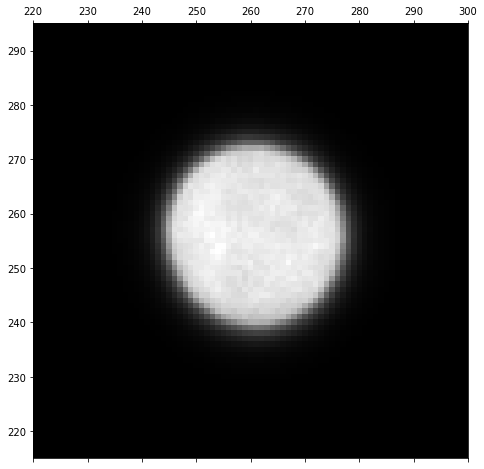

In [565]:
# Next, average all of the probe positions defined in this ROI mask
probe_aligned_03 = py4DSTEM.process.diskdetection.get_probe_from_4Dscan_ROI(dataset_03, image_mask_03, align=True)

# plot the output probe
fig, ax = py4DSTEM.visualize.show(probe_aligned_03, 
                                 returnfig=True)
ax.set_xlim(220, 300);
ax.set_ylim(215, 295);

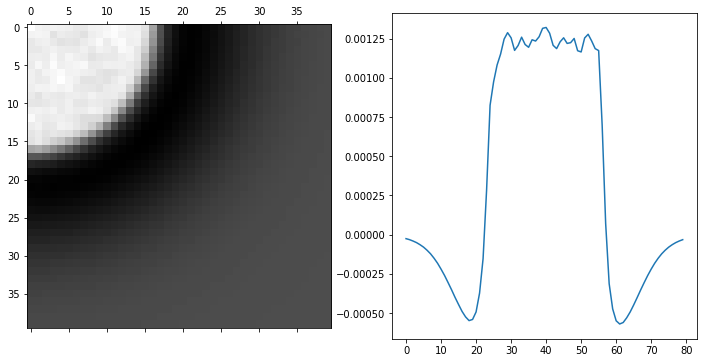

In [573]:
# Again the final step is to normalize the STEM probe and shift it to the origin
probe_kernel_03 = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(probe_aligned_03, 
                                                                               probe_03_radius * 1.0,
                                                                               probe_03_radius * 2.0,)
# Plot the probe kernel
py4DSTEM.visualize.show_kernel(probe_kernel_03, R=40, L=40, W=2)

In [ ]:
# Time to take a look at this data, both in real space and diffraction (reciprocal) space. 


In [ ]:
# Time to take a look at this data, both in real space and diffraction (reciprocal) space. 
# diffraction_pattern_mean_01 = np.mean(dataset_01.data, axis=(0,1))



diffraction_pattern_mean_01 = np.mean(dataset_01.data, axis=(0,1))
# diffraction_pattern_mean_01 = np.mean(dataset_01.data, axis=(0,1))
# # py4DSTEM.visualize.show(diffraction_pattern_mean_01, figsize=(2,2))
# # py4DSTEM.visualize.show(diffraction_pattern_mean_01, figsize=(2,2))
# # py4DSTEM.visualize.show_image_grid(diffraction_pattern_mean_01, H=1, W=1)
# vis.show_RQ(realspace_image=BF_image,
#             diffractionspace_image=datacube.data[4,7,:,:],
#             realspace_pdict={'cmap':'viridis'},
#             diffractionspace_pdict={'scaling':'power','power':0.5,
#                                     'clipvals':'std','min':1,'max':3})